In [ ]:
import os
import numpy as np
import pandas as pd
import random
import warnings

warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import Sequential, Model, regularizers
from tensorflow.keras.layers import (
    Dense, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dropout,
    GlobalAveragePooling2D, Activation, Add, GaussianNoise, Reshape,
    SpatialDropout2D, LeakyReLU, ReLU, Lambda, Input
)
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, AUC, Precision, Recall
from tensorflow.keras.applications import ResNet50V2, MobileNetV2
from tensorflow.keras.callbacks import (
    LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model, to_categorical

# Data Analysis and Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle, class_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.manifold import TSNE
import cv2

from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

Mounted at /content/drive


In [ ]:
classes = ['Cyst', 'Tumor', 'Stone', 'Normal']

In [ ]:
base_dir = '/content/drive/MyDrive/PolyCystic Kidney Disease/Dataset'

In [ ]:
data = []
valid_extensions = ('.jpg')  # Supported file extensions

for label in classes:
    folder_path = os.path.join(base_dir, label)

    # Check if the folder exists before attempting to access it
    if not os.path.isdir(folder_path):
        continue

    for file in os.listdir(folder_path):
        if file.lower().endswith(valid_extensions):  # Support for different extensions
            file_path = os.path.join(folder_path, file)
            data.append((file_path, label))

In [ ]:
print(data)
df = pd.DataFrame(data, columns=['file_path', 'label'])
df.head()



[('/content/drive/MyDrive/PolyCystic Kidney Disease/Dataset/Cyst/Cyst- (3373).jpg', 'Cyst'), ('/content/drive/MyDrive/PolyCystic Kidney Disease/Dataset/Cyst/Cyst- (3384).jpg', 'Cyst'), ('/content/drive/MyDrive/PolyCystic Kidney Disease/Dataset/Cyst/Cyst- (3374).jpg', 'Cyst'), ('/content/drive/MyDrive/PolyCystic Kidney Disease/Dataset/Cyst/Cyst- (3306).jpg', 'Cyst'), ('/content/drive/MyDrive/PolyCystic Kidney Disease/Dataset/Cyst/Cyst- (3275).jpg', 'Cyst'), ('/content/drive/MyDrive/PolyCystic Kidney Disease/Dataset/Cyst/Cyst- (3291).jpg', 'Cyst'), ('/content/drive/MyDrive/PolyCystic Kidney Disease/Dataset/Cyst/Cyst- (3235).jpg', 'Cyst'), ('/content/drive/MyDrive/PolyCystic Kidney Disease/Dataset/Cyst/Cyst- (3299).jpg', 'Cyst'), ('/content/drive/MyDrive/PolyCystic Kidney Disease/Dataset/Cyst/Cyst- (3231).jpg', 'Cyst'), ('/content/drive/MyDrive/PolyCystic Kidney Disease/Dataset/Cyst/Cyst- (3633).jpg', 'Cyst'), ('/content/drive/MyDrive/PolyCystic Kidney Disease/Dataset/Cyst/Cyst- (3626).jp

,file_path,label
0,/content/drive/MyDrive/PolyCystic Kidney Disea...,Cyst
1,/content/drive/MyDrive/PolyCystic Kidney Disea...,Cyst
2,/content/drive/MyDrive/PolyCystic Kidney Disea...,Cyst
3,/content/drive/MyDrive/PolyCystic Kidney Disea...,Cyst
4,/content/drive/MyDrive/PolyCystic Kidney Disea...,Cyst


In [ ]:
df['label'].value_counts()

,count
label,
Normal,5077
Cyst,3709
Tumor,2283
Stone,1377


In [ ]:
df.shape

(12446, 2)

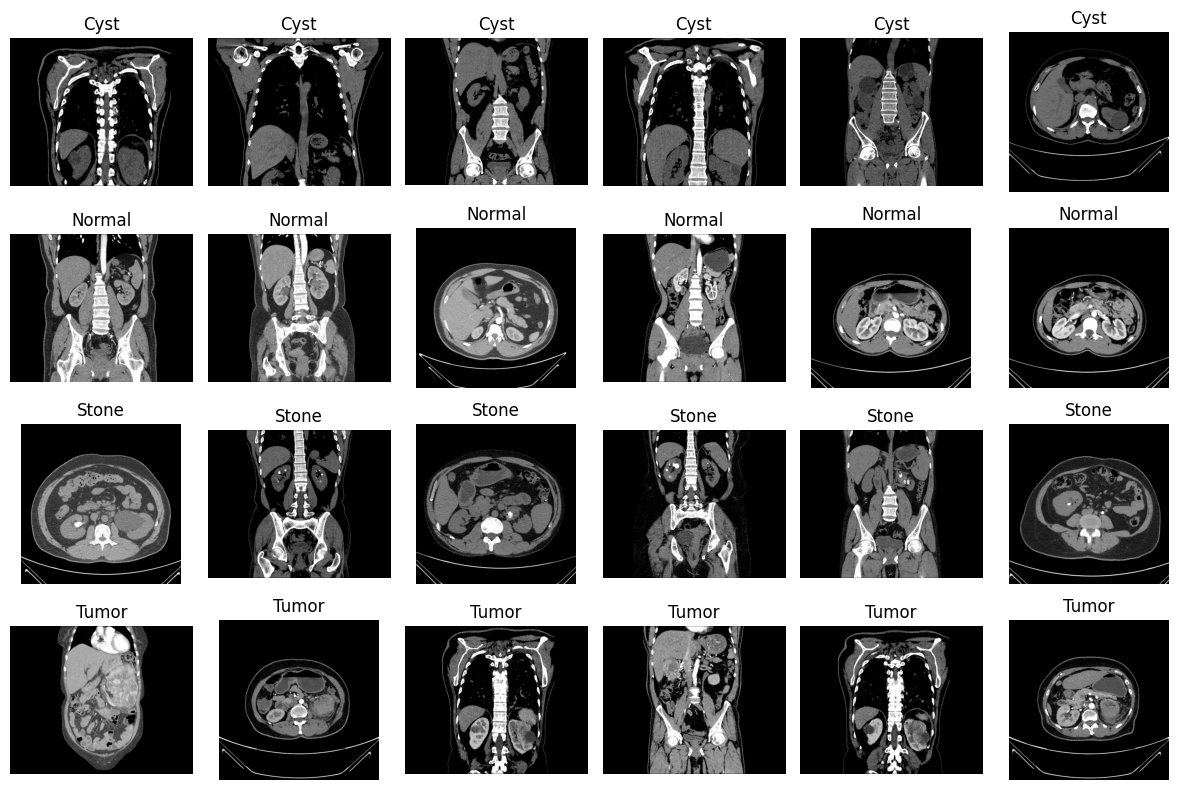

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# List of categories to display
classes_to_display = ['Cyst', 'Normal', 'Stone', 'Tumor']

# Set up the figure and axes (increase to 6 images per category)
fig, axes = plt.subplots(4, 6, figsize=(12, 8))  # Change columns to display 6 images
axes = axes.flatten()

# Display sample images
for i, label in enumerate(classes_to_display):
    class_data = df[df['label'] == label]
    sample_images = random.sample(list(class_data['file_path']), 6)

    for j, img_path in enumerate(sample_images):
        img = mpimg.imread(img_path)
        axes[i * 6 + j].imshow(img)
        axes[i * 6 + j].axis('off')
        axes[i * 6 + j].set_title(label)

plt.tight_layout()
plt.show()

In [ ]:
import os
import pandas as pd
from pathlib import Path

train_dir = Path("/content/drive/MyDrive/PolyCystic Kidney Disease/Dataset")


# Define paths for the four categories
normal_cases_dir = train_dir / 'Normal'
cyst_cases_dir = train_dir / 'Cyst'
stone_cases_dir = train_dir / 'Stone'
tumor_cases_dir = train_dir / 'Tumor'

# Retrieve the list of images for each category
normal_cases = list(normal_cases_dir.glob('*.jpg'))
cyst_cases = list(cyst_cases_dir.glob('*.jpg'))
stone_cases = list(stone_cases_dir.glob('*.jpg'))
tumor_cases = list(tumor_cases_dir.glob('*.jpg'))

# Create a list of images and their labels
train_data = []

for img in cyst_cases:
    train_data.append((str(img), 1))  # Class Cyst = 1
for img in normal_cases:
    train_data.append((str(img), 0))  # Class Normal = 0
for img in stone_cases:
    train_data.append((str(img), 3))  # Class Stone = 3
for img in tumor_cases:
    train_data.append((str(img), 2))  # Class Tumor = 2

# Convert the list into a DataFrame
train_data = pd.DataFrame(train_data, columns=['image', 'label'])

# Shuffle the data
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the data
print(train_data.head())

                                               image  label
0  /content/drive/MyDrive/PolyCystic Kidney Disea...      1
1  /content/drive/MyDrive/PolyCystic Kidney Disea...      1
2  /content/drive/MyDrive/PolyCystic Kidney Disea...      3
3  /content/drive/MyDrive/PolyCystic Kidney Disea...      1
4  /content/drive/MyDrive/PolyCystic Kidney Disea...      1


#Over Sampling

 Befor Oversampling:
label
0    5077
1    3709
2    2283
3    1377
Name: count, dtype: int64


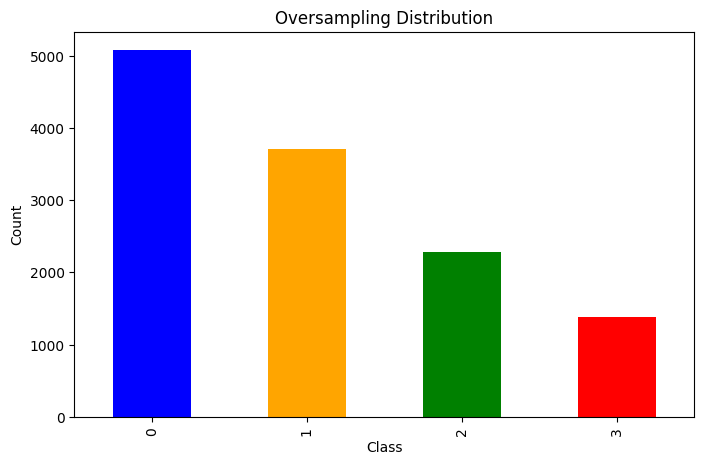

In [ ]:
import matplotlib.pyplot as plt

# Calculate the number of samples in each category
class_counts = train_data['label'].value_counts()
print(" Befor Oversampling:")
print(class_counts)

# Plot the distribution
plt.figure(figsize=(8,5))
class_counts.plot(kind='bar', color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Oversampling Distribution")
plt.show()

After Oversampling:
label
1    5077
0    5077
2    5077
3    5077
Name: count, dtype: int64


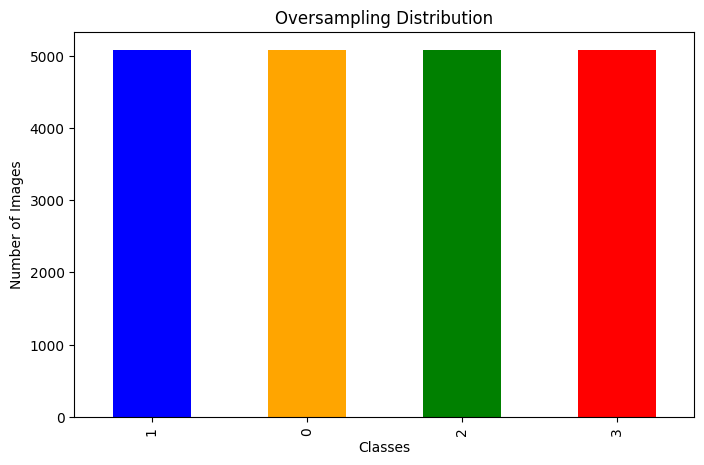

In [ ]:
from sklearn.utils import resample
import matplotlib.pyplot as plt

# Calculate the maximum number of samples in any category
max_count = class_counts.max()

# List to store the balanced data
balanced_data = []

# Apply oversampling to each category
for label, count in class_counts.items():
    subset = train_data[train_data['label'] == label]
    if count < max_count:
        subset = resample(subset, replace=True, n_samples=max_count, random_state=42)
    balanced_data.append(subset)

# Combine all categories after balancing
train_data_balanced = pd.concat(balanced_data)

# Shuffle the data randomly
train_data_balanced = train_data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new distribution
print("After Oversampling:")
print(train_data_balanced['label'].value_counts())

# Plot the distribution after oversampling
plt.figure(figsize=(8,5))
train_data_balanced['label'].value_counts().plot(kind='bar', color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Oversampling Distribution")
plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Copy of the original training data
train_data_balanced = train_data.copy()

# Create a RandomOverSampler instance to balance the classes
oversampler = RandomOverSampler(random_state=42)

# Apply oversampling to the data
X_resampled, y_resampled = oversampler.fit_resample(train_data_balanced[['image']], train_data_balanced['label'])

# Convert the resampled data into a new DataFrame
train_data_balanced = pd.DataFrame({'image': X_resampled['image'], 'label': y_resampled})

# Print the class distribution after oversampling
print(train_data_balanced['label'].value_counts())

label
1    5077
3    5077
2    5077
0    5077
Name: count, dtype: int64


##Split Data 80/20

In [ ]:
from sklearn.model_selection import train_test_split

#split data 80/20
train_data, test_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label'], random_state=42)

print("Training Set Distribution:\n", train_data['label'].value_counts())
print("Test Set Distribution:\n", test_data['label'].value_counts())

Training Set Distribution:
 label
0    4061
1    2967
2    1826
3    1102
Name: count, dtype: int64
Test Set Distribution:
 label
0    1016
1     742
2     457
3     275
Name: count, dtype: int64


In [ ]:
train_data['label'] = train_data['label'].astype(str)
test_data['label'] = test_data['label'].astype(str)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

#Create a copy of the original training data
train_data_balanced = train_data.copy()


oversampler = RandomOverSampler(random_state=42)

#oversample
X_resampled, y_resampled = oversampler.fit_resample(train_data_balanced[['image']], train_data_balanced['label'])

#convert the resampled data into a DataFrame
train_data_balanced = pd.DataFrame({'image': X_resampled['image'], 'label': y_resampled})

print(train_data_balanced['label'].value_counts())

label
0    4061
1    4061
3    4061
2    4061
Name: count, dtype: int64


In [ ]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Copy of the original training data
train_data_balanced = train_data.copy()

# Create a RandomOverSampler instance to balance the classes
oversampler = RandomOverSampler(random_state=42)

# Apply oversampling to the data
X_resampled, y_resampled = oversampler.fit_resample(train_data_balanced[['image']], train_data_balanced['label'])

# Convert the resampled data into a new DataFrame
train_data_balanced = pd.DataFrame({'image': X_resampled['image'], 'label': y_resampled})

# Print the class distribution after oversampling
print(train_data_balanced['label'].value_counts())

label
0    4061
1    4061
3    4061
2    4061
Name: count, dtype: int64


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1/255,           # Normalize pixel values to [0, 1]
    rotation_range=10,       # Rotate images by up to 10 degrees
    width_shift_range=0.12,  # Shift width by up to 12%
    height_shift_range=0.12, # Shift height by up to 12%
    shear_range=0.2,         # Apply shear transformations
    zoom_range=0.2,          # Zoom in or out by up to 20%
    horizontal_flip=True,    # Flip images horizontally
    fill_mode='nearest'      # Fill missing pixels with the nearest values
)

# Initialize ImageDataGenerator for test data without augmentation
test_datagen = ImageDataGenerator(rescale=1/255)

# Apply augmentation to the training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data_balanced,
    x_col='image',          # Column name for image paths
    y_col='label',          # Column name for labels
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=4,           # Use a batch size of 32
    class_mode='categorical', # Use categorical labels
    shuffle=True            # Shuffle data during training
)

# Prepare test data without augmentation
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image',          # Column name for image paths
    y_col='label',          # Column name for labels
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=4,           # Use a batch size of 32
    class_mode='categorical', # Use categorical labels
    shuffle=False           # Do not shuffle test data
)

Found 16244 validated image filenames belonging to 4 classes.
Found 2490 validated image filenames belonging to 4 classes.


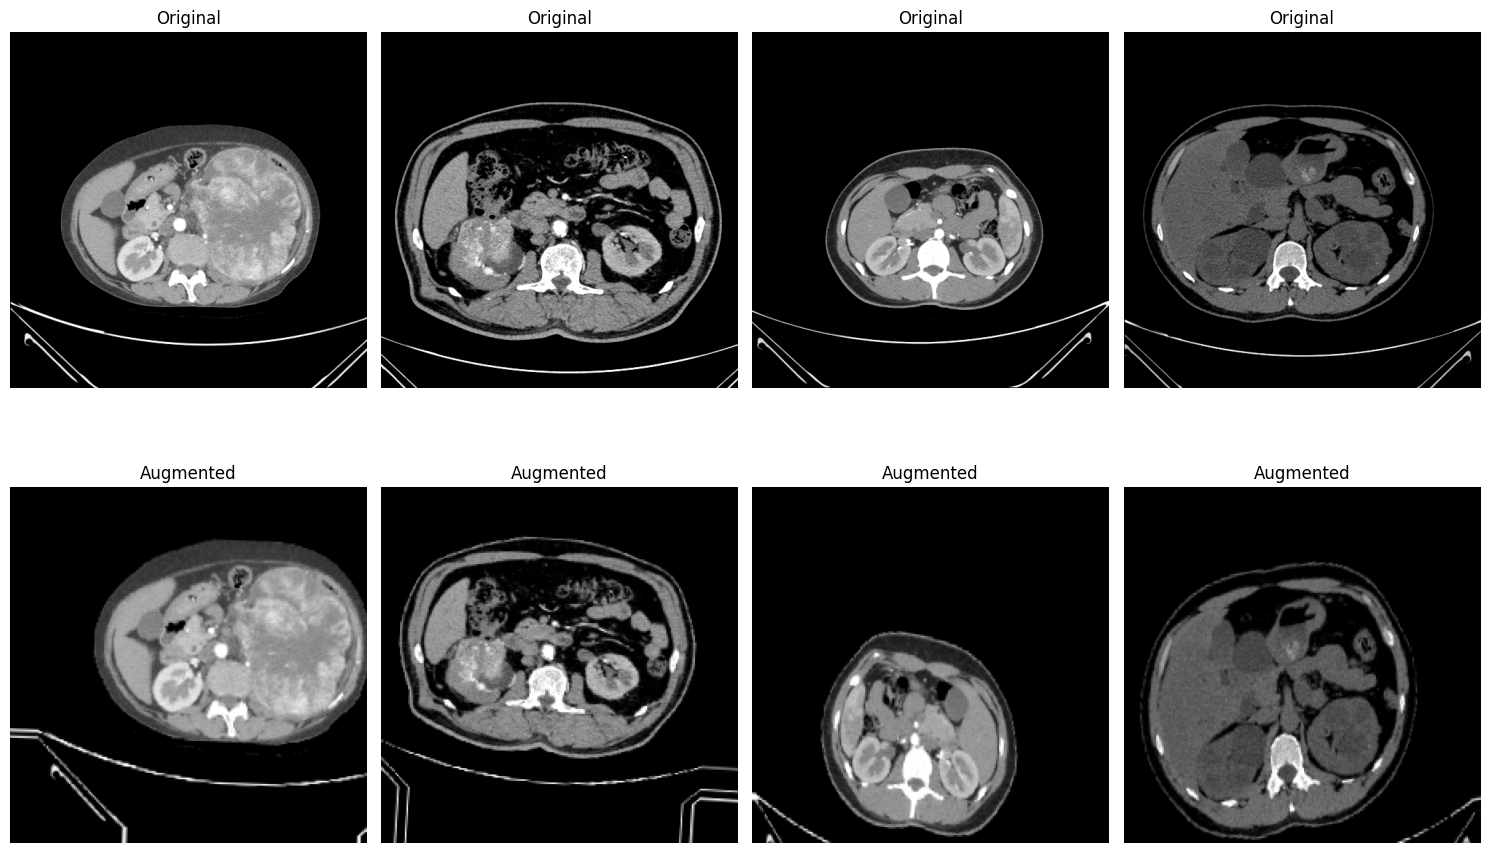

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to display
num_images = 6

# Retrieve a batch of images and labels from the generator
augmented_images, labels = next(train_generator)

# Ensure we don't exceed the available images
num_images = min(num_images, augmented_images.shape[0])

# Create a figure and display the images
fig, axes = plt.subplots(2, num_images, figsize=(15, 10))  # 2 rows for original and augmented

# Loop to display images
for i in range(num_images):
    # Original image (from the DataFrame)
    original_image_path = train_data_balanced.loc[train_generator.index_array[i], 'image']  # Get original image path
    original_image = plt.imread(original_image_path)                                  # Load original image

    # Display original image
    axes[0, i].imshow(original_image)
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    # Display augmented image
    augmented_image = augmented_images[i]
    augmented_image = np.clip(augmented_image, 0, 1)  # Ensure pixel values are in the [0, 1] range
    axes[1, i].imshow(augmented_image)
    axes[1, i].axis("off")
    axes[1, i].set_title("Augmented")

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Build the model
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))


model.add(Conv2D(64, (3, 3)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(GlobalMaxPooling2D())

model.add(Dense(256))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
model.add(Dense(128))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))


model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# Setup Callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/PolyCystic Kidney Disease/kidneymodel.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 109, 109, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 52, 52, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 256)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 256)                 │              

 Total params: 489,540 (1.87 MB)

 Trainable params: 488,580 (1.86 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

Epochs = 100

history = model.fit(
    train_generator,
    epochs=Epochs,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    validation_data=test_generator
)


model.save('/content/drive/MyDrive/PolyCystic Kidney Disease/kidneymodel.keras')




Epoch 1/100
4061/4061 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5537 - loss: 1.0347
Epoch 1: val_loss improved from inf to 0.27917, saving model to /content/drive/MyDrive/PolyCystic Kidney Disease/kidneymodel.keras
4061/4061 ━━━━━━━━━━━━━━━━━━━━ 6490s 2s/step - accuracy: 0.5537 - loss: 1.0346 - val_accuracy: 0.8891 - val_loss: 0.2792 - learning_rate: 1.0000e-04
Epoch 2/100
4061/4061 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8634 - loss: 0.3505
Epoch 2: val_loss did not improve from 0.27917
4061/4061 ━━━━━━━━━━━━━━━━━━━━ 252s 62ms/step - accuracy: 0.8634 - loss: 0.3505 - val_accuracy: 0.8690 - val_loss: 0.3928 - learning_rate: 1.0000e-04
Epoch 3/100
4061/4061 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9271 - loss: 0.1896
Epoch 3: val_loss improved from 0.27917 to 0.10170, saving model to /content/drive/MyDrive/PolyCystic Kidney Disease/kidneymodel.keras
4061/4061 ━━━━━━━━━━━━━━━━━━━━ 251s 62ms/step - accuracy: 0.9271 - loss: 0.1896 - val_accuracy: 0.9613 - val_loss: 0.101

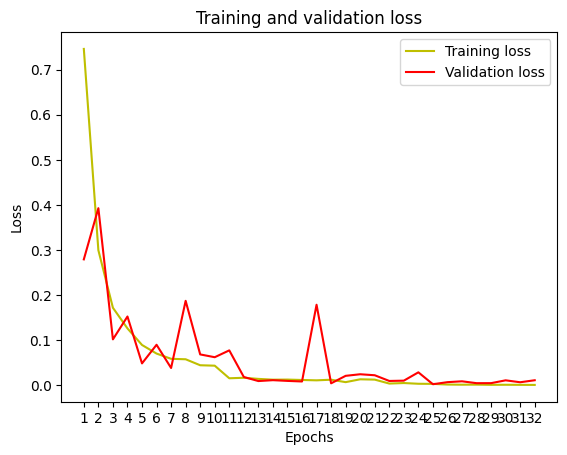

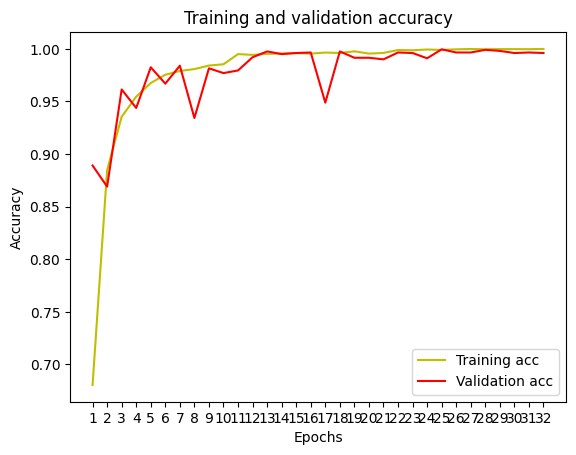

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs)
plt.show()


In [ ]:
import random
import pickle
import itertools
import numpy as np
from skimage.io import imshow
import matplotlib.pyplot as plt

def plot_segmentation_test(xval, yval, ypred, num_samples, class_names):
    fig = plt.figure(figsize=(16, 8))

    for i in range(num_samples):
        ix_val = random.randint(0, len(ypred) - 1)
        img = xval[ix_val]
        true_label = yval[ix_val]
        predicted_label = ypred[ix_val]

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')

        # Get class names from labels
        true_class_name = class_names[true_label]
        predicted_class_name = class_names[predicted_label]

        # Display prediction and ground truth as text
        plt.title(f"Prediction: {predicted_class_name}\nGround Truth: {true_class_name}")

    plt.tight_layout()
    plt.show()


623/623 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step


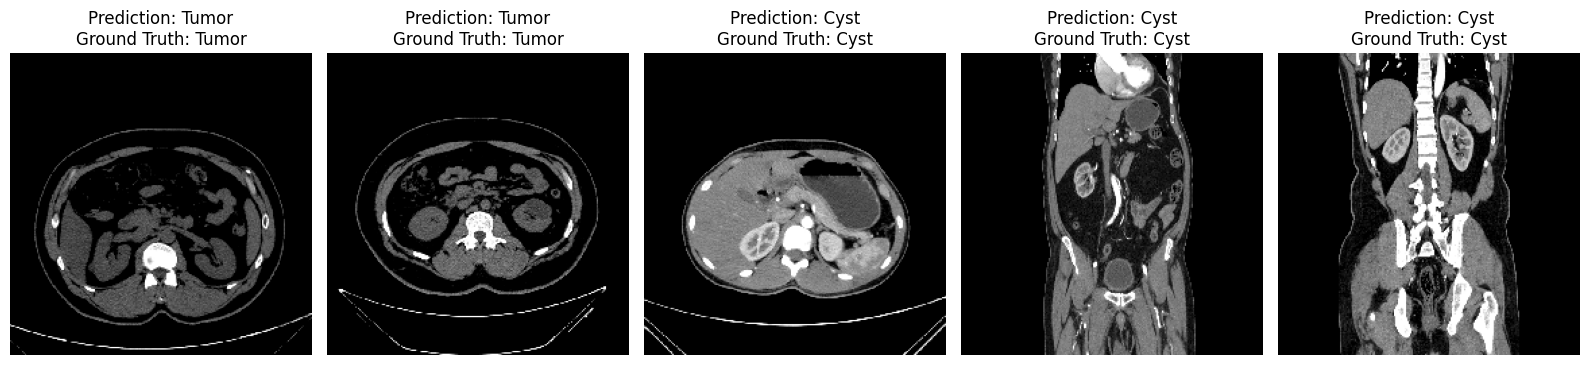

623/623 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9996 - loss: 0.0017
Test accuracy: 99.92%
Test loss: 0.0020
623/623 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step


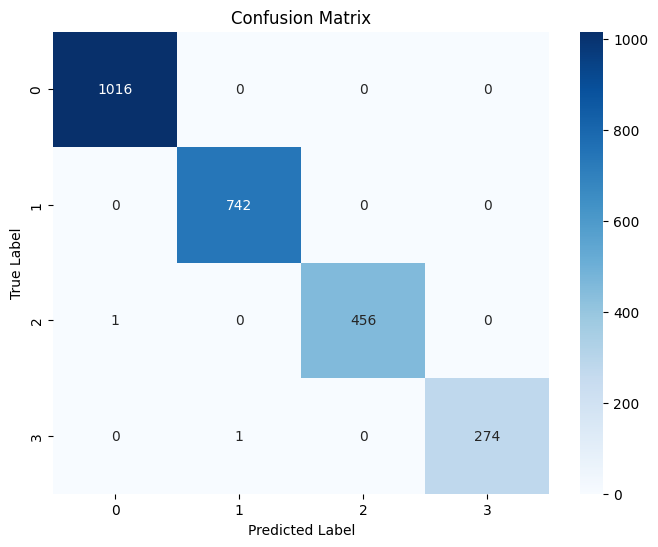

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

model = tf.keras.models.load_model('/content/drive/MyDrive/PolyCystic Kidney Disease/kidneymodel.keras')

test_generator.reset()

ypred = model.predict(test_generator)
ypred = np.argmax(ypred, axis=1)  # Convert predictions to class indices


xval = []
for _ in range(len(test_generator)):
    batch_x, _ = next(test_generator)
    xval.append(batch_x)
xval = np.concatenate(xval, axis=0)

yval = test_generator.classes


plot_segmentation_test(xval, yval, ypred, num_samples=5, class_names=classes)


test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc * 100:.2f}%')
print(f'Test loss: {test_loss:.4f}')


predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

#Generate and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()